In [1]:
# all the possible rolls
possible_values = [2, 3, 4, 5, 6]

# the weighted distribution of them
distribution = [1 , 4 , 10 , 12 , 9 ]
probabilities = [x/sum(distribution) for x in distribution]

# Keep a history of what we actually rolled
actual_distribution = [0] * 5

# For each partition we want to assign the best probable choice
priority = [5,4,6,3,2]

# ignore results over this many rolls
max_rolls = 35 

# number of cards to do for each layout
sample_size=100000

# number of competition rounds
competition_rounds = 100000

In [2]:
import collections
import numpy as np
import matplotlib.pyplot as plt

card_layouts = []

# it seems to perform better if the rolls are pre-determined
number_of_rolls_up_front = 1000000
rolls_up_front = np.random.choice(possible_values, number_of_rolls_up_front, p=probabilities)
roll_index = 0

def partition(number):
    """ Return all the partitions of 5 """
    answer = set()
    answer.add((number, ))
    for x in range(1, number):
        for y in partition(number - x):
            answer.add(tuple(sorted((x, ) + y, reverse=True)))
    return answer

def roll_the_dice():
    """ Return a dice roll and record what is was """
    global roll_index, rolls_up_front
    
    # we might need more along the way
    if roll_index >= number_of_rolls_up_front:
        roll_index = 0
        rolls_up_front = np.random.choice(possible_values, number_of_rolls_up_front, p=probabilities)
        
    r = rolls_up_front[roll_index]
    roll_index += 1
    actual_distribution[r-2] += 1
    return r
    

class CardLayout:
    def __init__(self, layout):
        self.layout = layout
        self.test_results = None
        self.add_test_results()
        
    def add_test_results(self):

        results = [0] * (max_rolls + 1)
        
        # run it for a given number of solo games
        for i in range(sample_size):
            
            # initialise the card from the template layout (one of the 7)
            # and roll count
            card = self.layout.copy()
            roll_count = 0

            # Bingo when our card is all zero entries
            # or quit if over the roll limit
            while roll_count < max_rolls and sum(card) > 0:

                # roll the dice
                rolled = roll_the_dice()
                roll_count += 1

                # mark the card
                if card[rolled - 2] > 0:
                    card[rolled - 2] -= 1

            # Bingo ?
            if sum(card) == 0:
                results[roll_count] += 1

        # only want from 5 to max_rolls
        results = results[5:max_rolls+1]
        
        # convert to %
        results = [r*100/sample_size for r in results]
        
        self.test_results = results

In [3]:
def setup():
    """ Create all 7 card layouts from the partitions of 5 and set the starting amounts based on 
    the priority of the distribution. i.e. largest partition gets the best probability
    """
    card_layouts.clear()
    for layout in partition(5):
        card_layout = [0] * 5
        for i,n in enumerate(layout):
            p = priority[i]
            card_layout[p-2] = n
        card_layouts.append(CardLayout(card_layout))
        
def run_competition(rounds=1000):
    """ Simulate a competition between all 7 layouts
    """
    # initialise the roll distribution
    dice_rolls = np.random.choice(possible_values, number_of_rolls_up_front, p=probabilities)
    
    # store how many wins for each card layout
    results = [0] * len(card_layouts)
    p = -1
    
    for _ in range(rounds-1):
        cards = [card.layout.copy() for card in card_layouts]
        bingo = False
        while not bingo:
            
            # get the next dice roll
            if p >= number_of_rolls_up_front:
                p = -1
                dice_rolls = np.random.choice(possible_values, number_of_rolls_up_front, p=probabilities)
                
            p += 1
            rolled = dice_rolls[p]
            
            # mark all the cards
            for i in range(len(cards)):
                card = cards[i]
                if card[rolled - 2] > 0:
                    card[rolled - 2] -= 1
                cards[i] = card
                
                # stop if a card has won
                if sum(card) == 0:
                    bingo = True
        
        # possibly more than 1 winner ?
        for i, card in enumerate(cards):
            if sum(card) == 0:
                results[i] += 1
    return results
            
            
        

In [4]:
setup()

expected_distribution_pct = [x*100/sum(probabilities) for x in probabilities]
actual_distribution_pct = [x*100/sum(actual_distribution) for x in actual_distribution]
actual_distribution_36 = [x*36/sum(actual_distribution) for x in actual_distribution]


Expected distribution [2.7777777777777777, 11.11111111111111, 27.77777777777778, 33.33333333333333, 25.0]
Actual distribution [2.777303192548298, 11.103493169659362, 27.806812328635818, 33.32178177669963, 24.99060953245689]


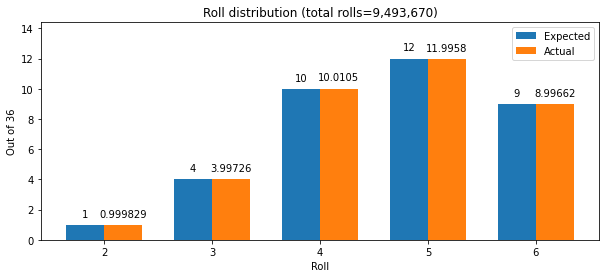

In [5]:
%matplotlib inline

print("Expected distribution", expected_distribution_pct)
print("Actual distribution", actual_distribution_pct)

x = np.arange(len(possible_values))  # the label locations
width = 0.35  # the width of the bars

# Report the distrubition of rolls

plt.figure(figsize=(10, 4))
b1 = plt.bar(x - width/2, distribution, width, label='Expected')
b2 = plt.bar(x + width/2, actual_distribution_36, width, label='Actual')
plt.bar_label(b1, padding=6)
plt.bar_label(b2, padding=6)

plt.title(f"Roll distribution (total rolls={sum(actual_distribution):,})")
plt.xlabel("Roll")
plt.xticks(x, possible_values)
plt.ylabel(f"Out of 36")
plt.legend()
plt.margins(y=0.2)
plt.show()


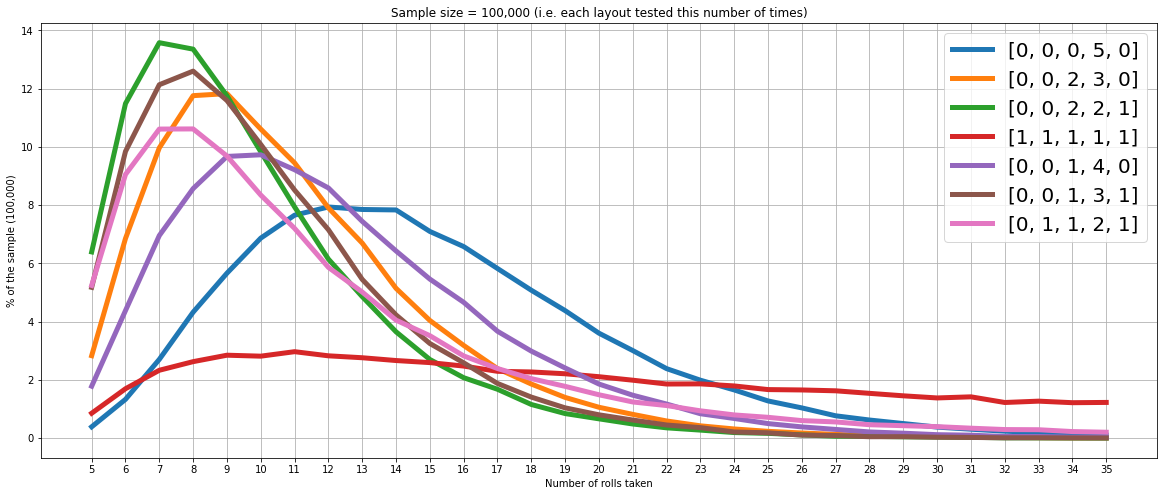

In [6]:
labels = list(range(5, max_rolls+1))
x = np.arange(len(labels))  # the label locations
line_colours = []

plt.figure(figsize=(20, 8))
for i,card in enumerate(card_layouts):
    p = plt.plot(labels,card.test_results, label = card.layout, linewidth=5)
    line_colours.append(p[-1].get_color())
    
plt.legend(loc=1, prop={'size': 20})
plt.grid()
plt.title(f"Sample size = {sample_size:,} (i.e. each layout tested this number of times)")
plt.xticks(labels)
plt.xlabel("Number of rolls taken")
plt.ylabel(f"% of the sample ({sample_size:,})")
plt.show()


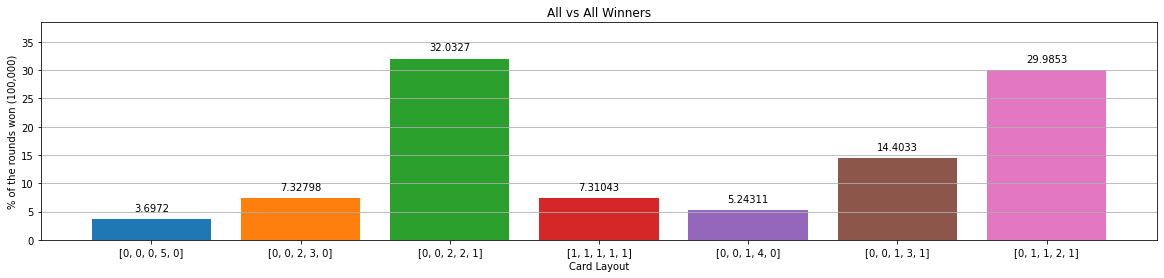

In [7]:
%matplotlib inline
competition_results = run_competition(competition_rounds)
competition_results_pct = [x*100/sum(competition_results) for x in competition_results]
plt.figure(figsize=(20, 4))
b=plt.bar([str(c.layout) for c in card_layouts],competition_results_pct, color=line_colours)
plt.title("All vs All Winners")
plt.xlabel("Card Layout")
plt.ylabel(f"% of the rounds won ({competition_rounds:,})")
plt.grid(axis='y')
plt.bar_label(b, padding=6)
plt.margins(y=0.2)
plt.show()